In [172]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

##Do I need all of these?
import sklearn.preprocessing as preprocessing
import statsmodels as sm
import sklearn as skl
import sklearn.preprocessing as preprocessing
import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
import sklearn.tree as tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import (cross_val_score, GridSearchCV, 
                                     train_test_split, StratifiedShuffleSplit)

from IPython.display import display
from numpy.random import RandomState

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler

In [173]:
import warnings
warnings.filterwarnings("ignore")

In [174]:
def _gridSearchCV(estimator, param_grid, X, y, test_size=0.2):
    grid_search = GridSearchCV(
        estimator=estimator(),
        param_grid=param_grid,
        cv=StratifiedShuffleSplit(n_splits=10, test_size=test_size),
        scoring=metrics.make_scorer(metrics.roc_auc_score),
        n_jobs=-1
    )
    grid_search.fit(X, y)
    return grid_search

In [ ]:

grid_search.fit(X_std, y_enc)
grid_search.best_params_

final_clf = tree.DecisionTreeClassifier(max_depth=7)
final_clf.fit(X_std, y_enc);

cv_results_df = pd.DataFrame(grid_search.cv_results_)
cv_results_df.sort_values(by="rank_test_score").head(5)

# Poisonous mushrooms
Get the data
## Interests
## Munging

In [175]:
#df = pd.read_csv('datasets/mushrooms.csv')
df = pd.read_csv('https://raw.githubusercontent.com/sventopia/ML/master/datasets/mushrooms.csv')
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [176]:
#remove entries with unknown stalk root
df = df[df['stalk-root'] != '?']

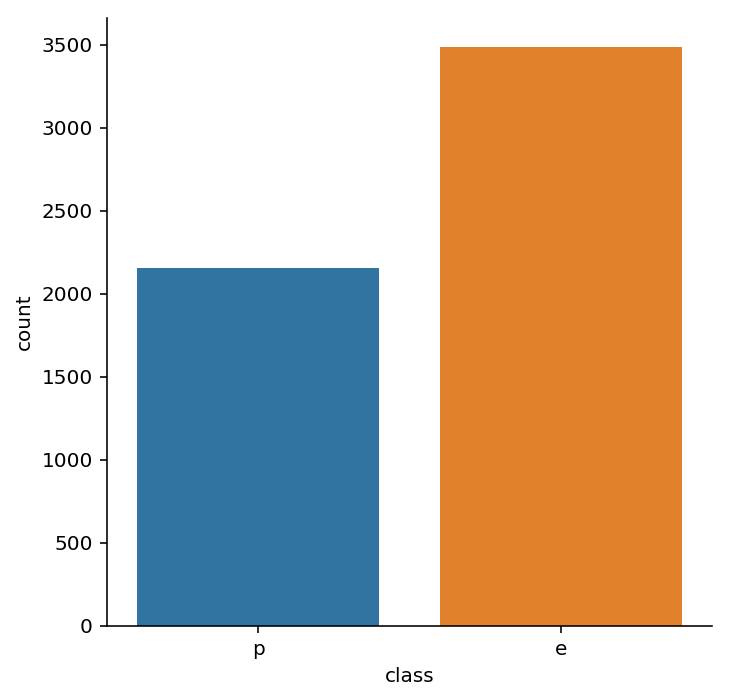

In [178]:
sns.catplot(
    x='class',
    data=df,
    kind='count')

In [179]:
#split off the response variable
y = df['class'].to_frame()
X = df.loc[:, df.columns != 'class']

In [180]:
#encode dummy variables
X_enc = pd.get_dummies(X)

#Scale
scaler = StandardScaler()
X_std = scaler.fit_transform(X_enc)

In [181]:
#encode the target variable
le = LabelEncoder()
y_enc = le.fit_transform(y.values.ravel())

### Decision trees

In [182]:
param_grid = [{
    'max_depth': list(range(1,10,1)),
    'criterion': ['gini','entropy']
}]
gs_dt_m = _gridSearchCV(
    tree.DecisionTreeClassifier, 
    param_grid,
    X_std, 
    y_enc)

In [221]:
#Save the metrics
params = gs_dt_m.best_params_
gs_dt_m_res = pd.DataFrame(gs_dt_m.cv_results_)

dt_y_pred_m = gs_dt_m.predict(X_std)

dt_accuracy_m = metrics.accuracy_score(y_enc, y_pred_m)
dt_AUROC_m = gs_dt_m.score(X_std, y_enc)
dt_confusion_mat_m= metrics.confusion_matrix(y_enc, y_pred_m)
dt_prfs_m = metrics.precision_recall_fscore_support(y_enc, y_pred_m)

dt_confusion_mat_frac_m = dt_confusion_mat_m / dt_prfs_m[3].sum()

params_dt_m = pd.DataFrame(
    gs_dt_m.best_params_,
    index=['decision tree best parameters']
)
gen_res_dt_m = pd.DataFrame(
    {'Accuracy': dt_accuracy_m,
     'AUROC-score': dt_AUROC_m
    },
    index=['decision tree']
)
class_res_dt_m = pd.DataFrame(
     {'Precision': dt_prfs_m[0],
     'Recall': dt_prfs_m[1],
     'F-score': dt_prfs_m[2],
     'Support': dt_prfs_m[3]
     },
    index=['edible','poisonous']
)

In [237]:
params_dt_m

,criterion,max_depth,Accuracy,AUROC-score
decision tree best parameters,gini,5,1.0,1.0


In [238]:
gen_res_dt_m

,Accuracy,AUROC-score
decision tree,1.0,1.0


In [239]:
class_res_dt_m

,Precision,Recall,F-score,Support
edible,1.0,1.0,1.0,3488
poisonous,1.0,1.0,1.0,2156


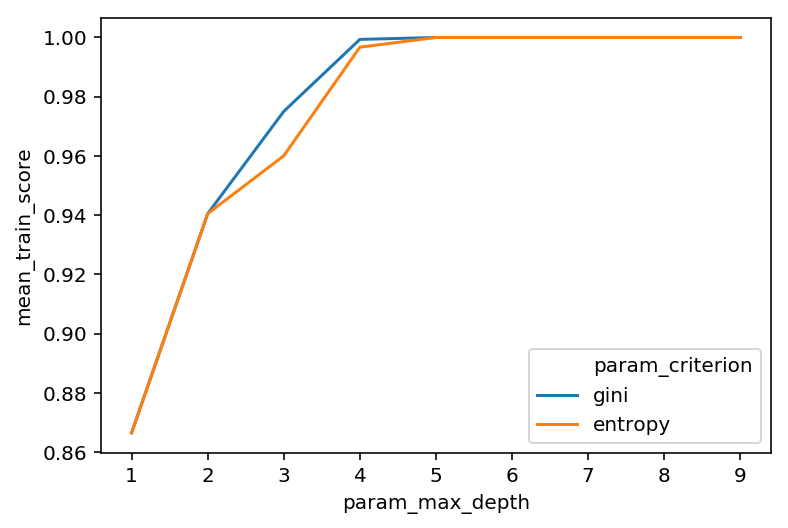

In [185]:
#learning curve
sns.lineplot(
    x='param_max_depth',
    y='mean_train_score',
    hue='param_criterion',
    data=gs_dt_m_res)

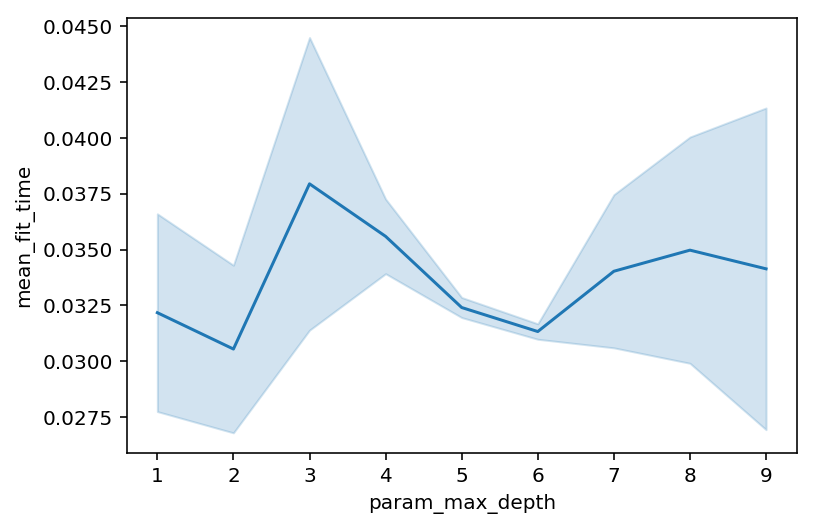

In [121]:
#computational performance
sns.lineplot(
    x='param_max_depth',
    y='mean_fit_time',
    data=cv_res_df_m)

### Boosting

In [124]:
### Boosting
param_grid = [{
    'n_estimators': list(range(5,25,1)),
    'max_depth': list(range(1,10,1)),
    'criterion': ['gini','entropy']
}]
gs_rf_m = _gridSearchCV(
    RandomForestClassifier, 
    param_grid,
    X_std, 
    y_enc)

In [240]:
#Save the metrics
params = gs_rf_m.best_params_
gs_rf_m_res = pd.DataFrame(gs_rf_m.cv_results_)

rf_y_pred_m = gs_rf_m.predict(X_std)

rf_accuracy_m = metrics.accuracy_score(y_enc, y_pred_m)
rf_AUROC_m = gs_rf_m.score(X_std, y_enc)
rf_confusion_mat_m= metrics.confusion_matrix(y_enc, y_pred_m)
rf_prfs_m = metrics.precision_recall_fscore_support(y_enc, y_pred_m)

rf_confusion_mat_frac_m = rf_confusion_mat_m / rf_prfs_m[3].sum()

params_rf_m = pd.DataFrame(
    gs_rf_m.best_params_,
    index=['random forests best parameters']
)
gen_res_rf_m = pd.DataFrame(
    {'Accuracy': rf_accuracy_m,
     'AUROC-score': rf_AUROC_m
    },
    index=['random forests']
)
class_res_rf_m = pd.DataFrame(
     {'Precision': rf_prfs_m[0],
     'Recall': rf_prfs_m[1],
     'F-score': rf_prfs_m[2],
     'Support': rf_prfs_m[3]
     },
    index=['edible','poisonous']
)

In [241]:
params_rf_m

,criterion,max_depth,n_estimators
random forests best parameters,gini,6,24


In [242]:
gen_res_rf_m

,Accuracy,AUROC-score
random forests,1.0,1.0


In [243]:
class_res_rf_m

,Precision,Recall,F-score,Support
edible,1.0,1.0,1.0,3488
poisonous,1.0,1.0,1.0,2156


### KNN

In [126]:
param_grid = [{
    'n_neighbors': list(range(1,3,1)),
    'weights': ['uniform','distance'],
    'metric': ['minkowski','manhattan']
}]
gs_knn_m = _gridSearchCV(
    neighbors.KNeighborsClassifier, 
    param_grid,
    X_std, 
    y_enc)

In [245]:
#Save the metrics
params = gs_knn_m.best_params_
gs_knn_m_res = pd.DataFrame(gs_knn_m.cv_results_)

knn_y_pred_m = gs_knn_m.predict(X_std)

knn_accuracy_m = metrics.accuracy_score(y_enc, y_pred_m)
knn_AUROC_m = gs_knn_m.score(X_std, y_enc)
knn_confusion_mat_m= metrics.confusion_matrix(y_enc, y_pred_m)
knn_prfs_m = metrics.precision_recall_fscore_support(y_enc, y_pred_m)

knn_confusion_mat_frac_m = knn_confusion_mat_m / knn_prfs_m[3].sum()

params_knn_m = pd.DataFrame(
    gs_knn_m.best_params_,
    index=['kNN best parameters']
)
gen_res_knn_m = pd.DataFrame(
    {'Accuracy': knn_accuracy_m,
     'AUROC-score': knn_AUROC_m
    },
    index=['kNN']
)
class_res_knn_m = pd.DataFrame(
     {'Precision': knn_prfs_m[0],
     'Recall': knn_prfs_m[1],
     'F-score': knn_prfs_m[2],
     'Support': knn_prfs_m[3]
     },
    index=['edible','poisonous']
)

In [246]:
params_knn_m

,metric,n_neighbors,weights
kNN best parameters,minkowski,1,uniform


In [247]:
gen_res_knn_m

,Accuracy,AUROC-score
kNN,1.0,1.0


In [248]:
class_res_knn_m

,Precision,Recall,F-score,Support
edible,1.0,1.0,1.0,3488
poisonous,1.0,1.0,1.0,2156


### SVM

In [128]:
param_grid = [{
    'kernel': ['linear','poly','rbf','sigmoid'],
    'degree': list(range(1,4,1)),
    'decision_function_shape': ['ovr','ovo']
}]
gs_svm_m = _gridSearchCV(
    SVC, 
    param_grid,
    X_std, 
    y_enc)

In [249]:
#Save the metrics
params = gs_svm_m.best_params_
gs_svm_m_res = pd.DataFrame(gs_svm_m.cv_results_)

svm_y_pred_m = gs_svm_m.predict(X_std)

svm_accuracy_m = metrics.accuracy_score(y_enc, y_pred_m)
svm_AUROC_m = gs_svm_m.score(X_std, y_enc)
svm_confusion_mat_m= metrics.confusion_matrix(y_enc, y_pred_m)
svm_prfs_m = metrics.precision_recall_fscore_support(y_enc, y_pred_m)

svm_confusion_mat_frac_m = svm_confusion_mat_m / svm_prfs_m[3].sum()

params_svm_m = pd.DataFrame(
    gs_svm_m.best_params_,
    index=['svm best parameters']
)
gen_res_svm_m = pd.DataFrame(
    {'Accuracy': svm_accuracy_m,
     'AUROC-score': svm_AUROC_m
    },
    index=['svm']
)
class_res_svm_m = pd.DataFrame(
     {'Precision': svm_prfs_m[0],
     'Recall': svm_prfs_m[1],
     'F-score': svm_prfs_m[2],
     'Support': svm_prfs_m[3]
     },
    index=['edible','poisonous']
)

In [250]:
params_svm_m

,decision_function_shape,degree,kernel
svm best parameters,ovr,1,linear


In [251]:
gen_res_svm_m

,Accuracy,AUROC-score
svm,1.0,1.0


In [252]:
class_res_svm_m

,Precision,Recall,F-score,Support
edible,1.0,1.0,1.0,3488
poisonous,1.0,1.0,1.0,2156


### Neural Networks

In [130]:
param_grid = [{
    'hidden_layer_sizes': [(n,) for n in list(range(1,20,1))],
    'solver': ['lbfgs','sgd','adam'],
    'activation': ['relu','logistic'],
    'learning_rate': ['constant','invscaling']
}]
gs_mlp_m = _gridSearchCV(
    MLPClassifier, 
    param_grid,
    X_std, 
    y_enc)

In [131]:
gs_mlp_m.best_params_

{'activation': 'relu',
 'hidden_layer_sizes': (6,),
 'learning_rate': 'constant',
 'solver': 'lbfgs'}

# Adult incomes
Get the data
## Interests
## Munging

In [164]:
#df = pd.read_csv('datasets/adult/adult.data.txt', header=None)
df = pd.read_csv('https://raw.githubusercontent.com/sventopia/ML/master/datasets/adult/adult.data.txt', header=None)
df.columns = ['age','workclass','fnlwgt','education','education-num','marital-status',
                  'occupation','relationship','race','sex','capital-gain','capital-loss',
                  'hours-per-week','native-country','income']

In [133]:
df = df.drop(['capital-gain','capital-loss'], axis=1)
#split off the response variable
y = df['income'].to_frame()
X = df.loc[:, df.columns != 'income']

In [134]:
#encode the target variable
le = LabelEncoder()
y_enc = le.fit_transform(y.values.ravel())

#encode dummy variables
X_enc = pd.get_dummies(X)

scaler = StandardScaler()
X_std = scaler.fit_transform(X_enc)

### Decision Trees

In [135]:
param_grid = [{
    'max_depth': list(range(1,10,1)),
    'criterion': ['gini','entropy']
}]
gs_dt_a = _gridSearchCV(
    tree.DecisionTreeClassifier, 
    param_grid,
    X_std, 
    y_enc)

In [136]:
gs_dt_a.best_params_

{'criterion': 'gini', 'max_depth': 7}

### Boosting

In [137]:
### Boosting
param_grid = [{
    'n_estimators': list(range(5,25,1)),
    'max_depth': list(range(1,10,1)),
    'criterion': ['gini','entropy']
}]
gs_rf_a = _gridSearchCV(
    RandomForestClassifier, 
    param_grid,
    X_std, 
    y_enc)

In [140]:
gs_rf_a.best_params_

{'criterion': 'entropy', 'max_depth': 9, 'n_estimators': 8}

### K-nearest neighbors

In [ ]:
param_grid = [{
    'n_neighbors': list(range(1,3,1)),
    'weights': ['uniform','distance'],
    'metric': ['minkowski','manhattan']
}]
gs_knn_a = _gridSearchCV(
    neighbors.KNeighborsClassifier, 
    param_grid,
    X_std, 
    y_enc)

In [ ]:
gs_knn_a.best_params_

### SVM

In [141]:
param_grid = [{
    'kernel': ['linear','poly','rbf','sigmoid'],
    'degree': list(range(1,4,1)),
    'decision_function_shape': ['ovr','ovo']
}]
gs_svm_a = _gridSearchCV(
    SVC, 
    param_grid,
    X_std, 
    y_enc)

KeyboardInterrupt: 

In [ ]:
gs_svm_a.best_params_

### Neural Networks

In [ ]:
param_grid = [{
    'hidden_layer_sizes': [(n,) for n in list(range(1,20,1))],
    'solver': ['lbfgs','sgd','adam'],
    'activation': ['relu','logistic'],
    'learning_rate': ['constant','invscaling']
}]
gs_mlp_a = _gridSearchCV(
    MLPClassifier, 
    param_grid,
    X_std, 
    y_enc)

In [ ]:
gs_mlp_a.best_params_